# Transfer Learning with Tensorflow Part 1: Feature Extraction
Tansfer learning is leveraging a working model's exsiting architecture and learned patterns for our own problem.
There are two main benefits:
1. Can leverage existing neural network architecture proven to work on problems similar to our own
2. Can leverage a working neural network archituture which has already learned patterns on similar data to our own, then we can adapt those patterns to our own data

In [1]:
!nvidia-smi

Tue Jan 10 22:45:10 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 528.02       Driver Version: 528.02       CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   34C    P8     4W /  50W |    550MiB /  4096MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Downloading and Seeing the Dataset

In [2]:
# Data (10% of 100 food classes from Food101)
import zipfile
#Unzip the download file
zip_ref=zipfile.ZipFile("10_food_classes_10_percent.zip")
zip_ref.extractall()
zip_ref.close()

In [3]:
## How many images in each folder?
import os

#walk through 10 % data directory and list numbers of files
for dirpath,dirnames,filenames in os.walk("10_food_classes_10_percent"):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in {dirpath} ")

There are 2 directories and 0 images in 10_food_classes_10_percent 
There are 10 directories and 0 images in 10_food_classes_10_percent\test 
There are 0 directories and 250 images in 10_food_classes_10_percent\test\chicken_curry 
There are 0 directories and 250 images in 10_food_classes_10_percent\test\chicken_wings 
There are 0 directories and 250 images in 10_food_classes_10_percent\test\fried_rice 
There are 0 directories and 250 images in 10_food_classes_10_percent\test\grilled_salmon 
There are 0 directories and 250 images in 10_food_classes_10_percent\test\hamburger 
There are 0 directories and 250 images in 10_food_classes_10_percent\test\ice_cream 
There are 0 directories and 250 images in 10_food_classes_10_percent\test\pizza 
There are 0 directories and 250 images in 10_food_classes_10_percent\test\ramen 
There are 0 directories and 250 images in 10_food_classes_10_percent\test\steak 
There are 0 directories and 250 images in 10_food_classes_10_percent\test\sushi 
There are 

## Create data loaders (preparing the data)
We'll use the ImageDataGenerator class to load in our images into batches

In [4]:
# Setup data input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
IMAGE_SHAPE=(224,224)
BATCH_SIZE=32

train_dir="10_food_classes_10_percent/train/"
test_dir="10_food_classes_10_percent/test/"
train_datagen=ImageDataGenerator(rescale=1/255.)
test_datagen=ImageDataGenerator(rescale=1/255.)

print("Training images:")
train_data_10_percent=train_datagen.flow_from_directory(train_dir,
                                                        target_size=IMAGE_SHAPE,
                                                        batch_size=BATCH_SIZE,
                                                        class_mode="categorical"
                                                       )
print("Test images:")
test_data_10_percent=test_datagen.flow_from_directory(test_dir,
                                                        target_size=IMAGE_SHAPE,
                                                        batch_size=BATCH_SIZE,
                                                        class_mode="categorical"
                                                       )


Training images:
Found 750 images belonging to 10 classes.
Test images:
Found 2500 images belonging to 10 classes.


## Setting up callbacks (things to run whilst our model trains)
Callbacks are extra functionality you can add to your models to be performed during or after training.
Some of most popular callbacks:
* Tracking experiments with TensorBorad callback
* Model checkpoint with ModelCheckpoint callback
* Stopping a model from training (before it trains too long and overfits) with EarlyStopping callback

In [5]:
# Create tensorboard callback (functionized because we need to create a new one for each model)
import datetime

def create_tensorboard_callback(dir_name,experiment_name):
    log_dir=dir_name+"/"+experiment_name+"/"+datetime.datetime.now().strftime("%d%m%Y-%H%M%S")
    tensorboard_callback=tf.keras.callbacks.TensorBoard(log_dir=log_dir)
    print(f"Saving Tensorboard log files to:{log_dir}")
    return tensorboard_callback

## Creating model using Tensorflow hub
In the past we've used TensorFLow to create our own models layer by layer from scratch.

Now we're going to do similar process, except the majority of our model's layers are going to come from TensorFlow hub.

We can access pretrained models on : https://tfhub.dev/

Browsing the TensorFlow hub page , we found and sorting for image classification , we found the following feature vector model link:
https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1

In [6]:
#Let's compare the following two models
resnet_url="https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/5"

efficient_url="https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"

In [7]:
IMAGE_SHAPE+(3,)

(224, 224, 3)

In [8]:
#import dependencies
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

In [9]:
#Let's make a create_model() function to create model from URL
def create_model(model_url,num_classes=10):
    """
    Takes a Tensorflow Hub URL and create a Keras Sequential model with it.
    
    Args:
    model_url(str): A Tensorflow Hub feature extraction URL.
    
    num_classes(int): Number of output neurons in output layer,
    should be equal to number of target classes, default 10.
    
    Returns:
    An uncompiled Keras Sequential model with model_url as feature extractor
    layer and Dense output layer with num_classes output neurons.
    
    """
    
    # Download the pretrained model and save it as Keras layer
    feature_extractor_layer=hub.KerasLayer(model_url,
                                          trainable=False, # freeze already trained patterns
                                          name="feature_extraction_layer",
                                          input_shape=IMAGE_SHAPE+(3,)
                                          )

    # Create our own model
    model=tf.keras.Sequential([
        feature_extractor_layer,
        layers.Dense(num_classes,activation="softmax",name="output_layer")
    ])
    
    return model

### Creating and Testing Resnet Tensorflow Hub Feature Extraction model

In [10]:
# Create Resent model
resnet_model=create_model(resnet_url,num_classes=train_data_10_percent.num_classes)

In [11]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 2048)             23564800  
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


In [12]:
from tensorflow.keras.optimizers import Adam

In [13]:
#Compile our model
resnet_model.compile(
  loss=tf.keras.losses.CategoricalCrossentropy(),
  optimizer= Adam(),
  metrics=["accuracy"]  
)

In [14]:
#fit the model
resnet_history=resnet_model.fit(
  train_data_10_percent,
  epochs=5,
  steps_per_epoch=len(train_data_10_percent),
   validation_data=test_data_10_percent,
   validation_steps=len(test_data_10_percent),
   callbacks=create_tensorboard_callback(dir_name="Tensorflow hub",
                                         experiment_name="resnet50V2"    
                                        ) 
)

Saving Tensorboard log files to:Tensorflow hub/resnet50V2/10012023-224530
Epoch 1/5
24/24 [==============================] - 31s 754ms/step - loss: 1.9764 - accuracy: 0.3347 - val_loss: 1.2939 - val_accuracy: 0.5740
Epoch 2/5
24/24 [==============================] - 15s 638ms/step - loss: 0.9133 - accuracy: 0.7333 - val_loss: 0.8891 - val_accuracy: 0.7108
Epoch 3/5
24/24 [==============================] - 15s 636ms/step - loss: 0.6206 - accuracy: 0.8307 - val_loss: 0.7651 - val_accuracy: 0.7496
Epoch 4/5
24/24 [==============================] - 15s 637ms/step - loss: 0.4739 - accuracy: 0.8907 - val_loss: 0.7117 - val_accuracy: 0.7676
Epoch 5/5
24/24 [==============================] - 15s 635ms/step - loss: 0.3786 - accuracy: 0.9200 - val_loss: 0.6810 - val_accuracy: 0.7836


In [15]:
# Function to plot loss curves
#Plot the validation and training curves seperately
import matplotlib.pyplot as plt
def plot_loss_curves(history):
  """
  Returns seperate loss curves for training and validation metrics.
  """
  loss=history.history["loss"]
  val_loss=history.history["val_loss"]

  accuracy=history.history["accuracy"]
  val_accuracy=history.history["val_accuracy"]

  epochs=range(len(history.history["loss"]))

  #Plot loss
  plt.plot(epochs,loss,label="training_loss")
  plt.plot(epochs,val_loss,label="val_loss")
  plt.title("loss")
  plt.xlabel("epochs")
  plt.legend()

  #Plot accuracy
  plt.figure()
  plt.plot(epochs,accuracy,label="training_accuracy")
  plt.plot(epochs,val_accuracy,label="val_accuracy")
  plt.title("accuracy")
  plt.xlabel("epochs")
  plt.legend();

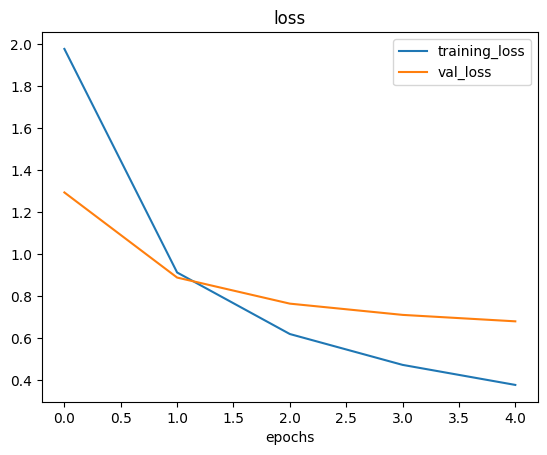

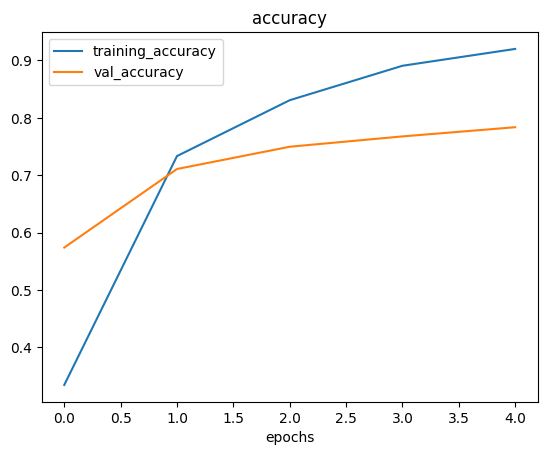

In [16]:
plot_loss_curves(resnet_history)

## Creating and testing EfficientNetB0 Tensorflow hub feature Extraction model

In [17]:
## Creating model
efficient_model=create_model(efficient_url,num_classes=train_data_10_percent.num_classes)

In [18]:
#Compile
efficient_model.compile(
 loss=tf.keras.losses.CategoricalCrossentropy(),
 optimizer=Adam(),
 metrics=["accuracy"]   
)

In [19]:
#Fit the model
efficient_history=efficient_model.fit(train_data_10_percent,
                                      epochs=5,
                                      steps_per_epoch=len(train_data_10_percent),
                                      validation_data=test_data_10_percent,
                                      validation_steps=len(test_data_10_percent),
                                      callbacks=create_tensorboard_callback(dir_name="Tensorflow hub",
                                                                           experiment_name="EfficientNetB0")
                                     )

Saving Tensorboard log files to:Tensorflow hub/EfficientNetB0/10012023-224711
Epoch 1/5
24/24 [==============================] - 23s 599ms/step - loss: 1.8640 - accuracy: 0.3947 - val_loss: 1.3058 - val_accuracy: 0.7112
Epoch 2/5
24/24 [==============================] - 11s 482ms/step - loss: 1.0769 - accuracy: 0.7613 - val_loss: 0.8783 - val_accuracy: 0.8160
Epoch 3/5
24/24 [==============================] - 11s 474ms/step - loss: 0.7717 - accuracy: 0.8120 - val_loss: 0.6976 - val_accuracy: 0.8424
Epoch 4/5
24/24 [==============================] - 11s 475ms/step - loss: 0.6211 - accuracy: 0.8560 - val_loss: 0.6080 - val_accuracy: 0.8580
Epoch 5/5
24/24 [==============================] - 11s 473ms/step - loss: 0.5186 - accuracy: 0.8880 - val_loss: 0.5544 - val_accuracy: 0.8632


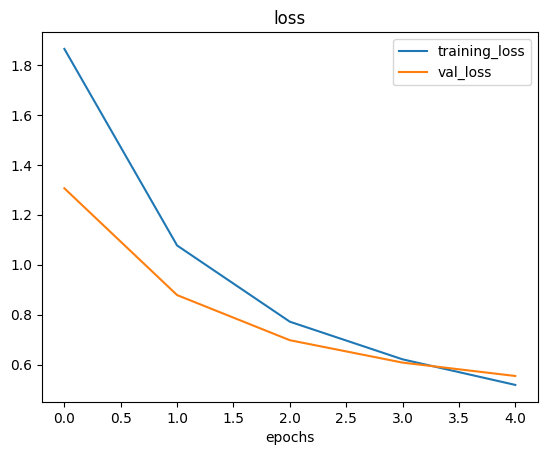

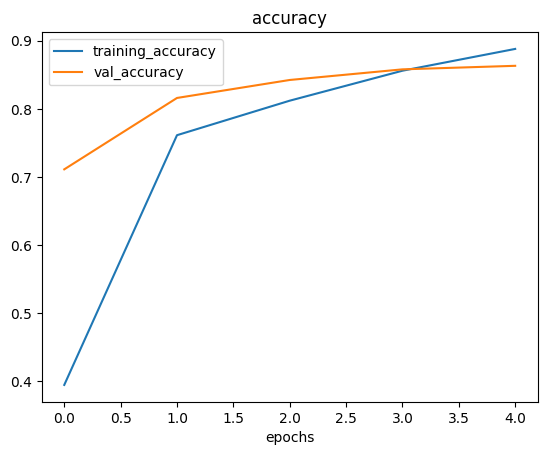

In [20]:
plot_loss_curves(efficient_history)

In [21]:
efficient_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 1280)             4049564   
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,374
Trainable params: 12,810
Non-trainable params: 4,049,564
_________________________________________________________________


In [22]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 2048)             23564800  
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


In [23]:
!nvidia-smi


Tue Jan 10 22:48:19 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 528.02       Driver Version: 528.02       CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   50C    P0    21W /  50W |   3264MiB /  4096MiB |     61%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Different types of Transfer learning
* **"As is" transfer learning** - is when you take a pretrained model as it is and apply it to your task without any changes.
For example, many computer vision models are pretrained on the ImageNet dataset which contains 1000 different classes of images. This means passing a single image to this model will produce 1000 different prediction probability values (1 for each class).

This is helpful if you have 1000 classes of image you'd like to classify and they're all the same as the ImageNet classes, however, it's not helpful if you want to classify only a small subset of classes (such as 10 different kinds of food). Model's with "/classification" in their name on TensorFlow Hub provide this kind of functionality.

* **Feature extraction** transfer learning- is when you take the underlying patterns (also called weights) a pretrained model has learned and adjust its outputs to be more suited to your problem.
For example, say the pretrained model you were using had 236 different layers (EfficientNetB0 has 236 layers), but the top layer outputs 1000 classes because it was pretrained on ImageNet. To adjust this to your own problem, you might remove the original activation layer and replace it with your own but with the right number of output classes. The important part here is that only the top few layers become trainable, the rest remain frozen.

This way all the underlying patterns remain in the rest of the layers and you can utilise them for your own problem. This kind of transfer learning is very helpful when your data is similar to the data a model has been pretrained on.



* **"Fine-tuning"** transfer learning - use the prelearned patterns of an existing model and "fine-tune" many or all of the underlying layers (including new output layer)

In [24]:
## How many layers does our efficientnetb0 feature extractor have?
len(efficient_model.layers[0].weights)

309

## Comparing our model results using TensorBoard

In [25]:
#   # Upload TensorBoard dev records
# !tensorboard dev upload --logdir ./Tensorflow hub/ \
#   --name "EfficientNetB0 vs. ResNet50V2" \
#   --description "Comparing two different TF Hub feature extraction models architectures using 10% of training images" \
#   --one_shot       #Cant run on jupyter so run these on google collab

# Excersise Questions

## Q1 Build and fit a model using the same data we have here but with the MobileNetV2 architecture feature extraction (mobilenet_v2_100_224/feature_vector) from TensorFlow Hub, how does it perform compared to our other models?

In [26]:
mobilenet_url="https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/5"

In [27]:
mobilenet_model=create_model(mobilenet_url,train_data_10_percent.num_classes)

In [28]:
#compile the model
mobilenet_model.compile(
 loss=tf.keras.losses.CategoricalCrossentropy(),
 optimizer=Adam(),
 metrics=["accuracy"]   
)

In [29]:
#fit the model
mobilenet_history=mobilenet_model.fit(
   train_data_10_percent,
   epochs=5,
   steps_per_epoch=len(train_data_10_percent),
   validation_data=test_data_10_percent,
   validation_steps=len(test_data_10_percent) 
)

Epoch 1/5
24/24 [==============================] - 14s 425ms/step - loss: 1.9999 - accuracy: 0.3187 - val_loss: 1.3205 - val_accuracy: 0.6100
Epoch 2/5
24/24 [==============================] - 9s 376ms/step - loss: 1.0372 - accuracy: 0.7187 - val_loss: 0.8833 - val_accuracy: 0.7504
Epoch 3/5
24/24 [==============================] - 9s 385ms/step - loss: 0.7321 - accuracy: 0.8093 - val_loss: 0.7450 - val_accuracy: 0.7856
Epoch 4/5
24/24 [==============================] - 9s 396ms/step - loss: 0.5841 - accuracy: 0.8533 - val_loss: 0.6910 - val_accuracy: 0.7864
Epoch 5/5
24/24 [==============================] - 9s 374ms/step - loss: 0.4831 - accuracy: 0.8760 - val_loss: 0.6383 - val_accuracy: 0.8040


## Q2. Build a model to classify images of two different things you've taken photos of.

In [30]:
train_dir="Excersise/train"
test_dir="Excersise/test"

In [31]:
import pathlib
import numpy as np
data_dir=pathlib.Path("Excersise/train")
class_names=np.array(sorted([item.name for item in data_dir.glob("*")]))#Created a list of class_names from sub-directories
print(class_names)

['fridge' 'oven']


In [32]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen=ImageDataGenerator(rescale=1/255.,
                                 rotation_range=0.2,
                                 shear_range=0.2,
                                 zoom_range=0.2,
                                 width_shift_range=0.2,
                                 height_shift_range=0.2,
                                 horizontal_flip=True
                                )

test_datagen=ImageDataGenerator(rescale=1/255.)

In [33]:
IMG_SHAPE=(224,224)

In [34]:
train_data=train_datagen.flow_from_directory(train_dir,
                                             class_mode="binary",
                                             target_size=IMG_SHAPE,
                                             batch_size=32
                                            )

Found 10 images belonging to 2 classes.


In [35]:
test_data=test_datagen.flow_from_directory(test_dir,
                                           target_size=IMG_SHAPE,
                                           batch_size=32,
                                           class_mode="binary"
                                          )

Found 10 images belonging to 2 classes.


In [36]:
import tensorflow as tf
from tensorflow.keras.layers import Flatten,Dense,Conv2D,MaxPool2D
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import Adam

In [37]:
#Built CNN model
Ex_3_model=Sequential([
    Conv2D(10,3,input_shape=(224,224,3),activation="relu"),
    Conv2D(10,3,activation="relu"),
    MaxPool2D(pool_size=3),
    Conv2D(10,3,activation="relu"),
    Conv2D(10,3,activation="relu"),
    MaxPool2D(),
    Flatten(),
    Dense(1,activation="sigmoid")
])

In [38]:
Ex_3_model.compile(
  loss=tf.keras.losses.BinaryCrossentropy(),
  optimizer=Adam(),
   metrics=["accuracy"]  
)

In [39]:
Ex_model_history=Ex_3_model.fit(
   train_data,
    epochs=5,
    steps_per_epoch=len(train_data),
    validation_data=test_data,
    validation_steps=len(test_data)
)

Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 0.6750 - accuracy: 0.7000

C:\Users\Mudit\AppData\Local\Programs\Python\Python310\lib\site-packages\PIL\Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


1/1 [==============================] - 3s 3s/step - loss: 0.6750 - accuracy: 0.7000 - val_loss: 0.6383 - val_accuracy: 0.8000
Epoch 2/5
1/1 [==============================] - 1s 552ms/step - loss: 0.6576 - accuracy: 0.7000 - val_loss: 0.6191 - val_accuracy: 0.8000
Epoch 3/5
1/1 [==============================] - 1s 556ms/step - loss: 0.6761 - accuracy: 0.6000 - val_loss: 0.6129 - val_accuracy: 0.5000
Epoch 4/5
1/1 [==============================] - 1s 596ms/step - loss: 0.5815 - accuracy: 0.9000 - val_loss: 0.5914 - val_accuracy: 0.8000
Epoch 5/5
1/1 [==============================] - 1s 699ms/step - loss: 0.5545 - accuracy: 0.8000 - val_loss: 0.5374 - val_accuracy: 0.8000


In [40]:
def load_and_prep_image(filename,img_shape=224):
    """"
    Read an image from filename, turns it into tensor 
    and reshapes it to(img_shape,color_channels)
    """
    #Read in the image
    img=tf.io.read_file(filename)
    #Decode the read file into tensor
    img=tf.image.decode_image(img)
    #Resize the image
    img=tf.image.resize(img,size=[img_shape,img_shape])
    #Rescale the img ,normalization
    img=img/255.
    return img

In [41]:

def pred_and_plot(model, filename, class_names):
  """
  Imports an image located at filename, makes a prediction on it with
  a trained model and plots the image with the predicted class as the title.
  """
  # Import the target image and preprocess it
  img = load_and_prep_image(filename)

  # Make a prediction
  pred = model.predict(tf.expand_dims(img, axis=0))

  # Get the predicted class
  pred_class = class_names[int(tf.round(pred))]

  # Plot the image and predicted class
  plt.imshow(img)
  plt.title(f"Prediction: {pred_class}")
  plt.axis(False);
     

1/1 [==============================] - 3s 3s/step


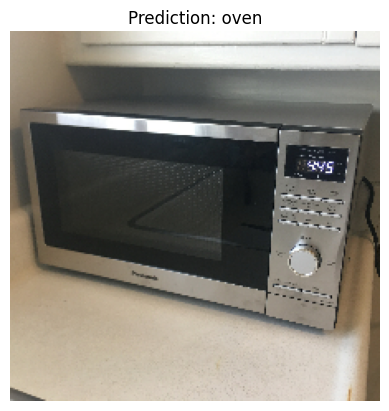

In [42]:
pred_and_plot(Ex_3_model,"Microwave_2022.jpg",class_names)

1/1 [==============================] - 0s 19ms/step


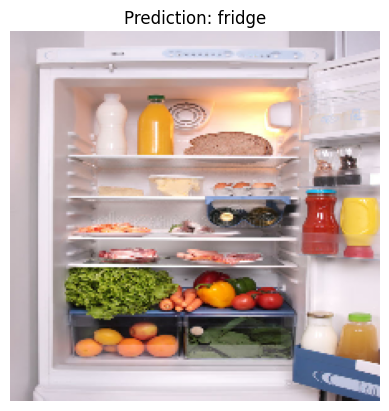

In [43]:
pred_and_plot(Ex_3_model,"refrigerator-full-some-kinds-food-11895048.jpg",class_names)

In [44]:
##Using efficient net
feature_extractor_layer=hub.KerasLayer(
    efficient_url,
    trainable=False,
    input_shape=(224,224,3)
)

In [45]:
Ex_model_efficient=Sequential([
    feature_extractor_layer,
    Dense(1,activation="sigmoid")
])

In [46]:
Ex_model_efficient.compile(
loss=tf.keras.losses.BinaryCrossentropy(),
optimizer=Adam(),
metrics=["accuracy"]    
)

In [48]:
Ex_efficient_history=Ex_model_efficient.fit(
 train_data,
    epochs=5,
    steps_per_epoch=len(train_data),
    validation_data=test_data,
    validation_steps=len(test_data)
)

Epoch 1/5
1/1 [==============================] - 1s 1s/step - loss: 0.5859 - accuracy: 0.8000 - val_loss: 0.5697 - val_accuracy: 0.9000
Epoch 2/5
1/1 [==============================] - 1s 569ms/step - loss: 0.5445 - accuracy: 0.8000 - val_loss: 0.5338 - val_accuracy: 1.0000
Epoch 3/5
1/1 [==============================] - 1s 601ms/step - loss: 0.4775 - accuracy: 1.0000 - val_loss: 0.5005 - val_accuracy: 1.0000
Epoch 4/5
1/1 [==============================] - 1s 684ms/step - loss: 0.4581 - accuracy: 1.0000 - val_loss: 0.4691 - val_accuracy: 1.0000
Epoch 5/5
1/1 [==============================] - 1s 563ms/step - loss: 0.4446 - accuracy: 0.9000 - val_loss: 0.4398 - val_accuracy: 1.0000


1/1 [==============================] - 2s 2s/step


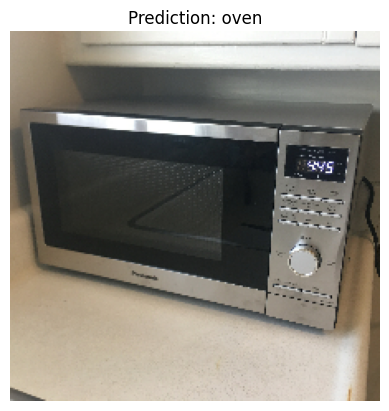

In [49]:
pred_and_plot(Ex_model_efficient,"Microwave_2022.jpg",class_names)

1/1 [==============================] - 0s 33ms/step


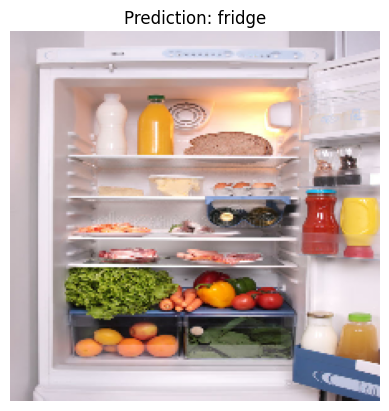

In [50]:
pred_and_plot(Ex_model_efficient,"refrigerator-full-some-kinds-food-11895048.jpg",class_names)